In [22]:
import matplotlib.pyplot as plt
import numpy as np
import copy
import scipy as si
import os
import scipy.stats as stats
cwd = os.getcwd()
plots = os.path.join(cwd, 'plots')
max_anlge = 59.2 #deg



def read_from(data, theta, max_anlge = 59.2):
    time = (data[0] - data[0][0])*1e-6 #time in seconds
    angles = np.array([data[9], data[10]])
    tangents  = np.array([data[7], data[8]])
    quadrants = np.array([data[2], data[3], data[4], data[5]])
    totals = data[6]
    gamma = data[1]/16*0.9
    tan_gamma = np.tan(gamma/180*np.pi)
    # this is true_alpha, true_beta type shape
    true_tangents =  np.array([tan_gamma * np.cos(theta/180*np.pi),- tan_gamma * np.sin(theta/180*np.pi)])
    true_angles = np.array([np.arctan(true_tangents[0])*180/np.pi, np.arctan(true_tangents[1])*180/np.pi])
    # find the limits in which the sun sensor works
    dgsa = (true_angles[0] < max_anlge) & (true_angles[0] > -max_anlge)
    dgsb = (true_angles[1] < max_anlge) & (true_angles[1] > -max_anlge)
    return {"time": time, "quadrants": quadrants, "totals": totals,
            "angles": angles, "tangents": tangents, "true_angles": true_angles,
            "true_tangents": true_tangents, "limits": dgsa & dgsb}

calb_data = [read_from((np.loadtxt(cwd + r'\data\180_1_70max', skiprows=1, delimiter=',')).T, 180),
             read_from((np.loadtxt(cwd + r'\data\135_1_70max', skiprows=1, delimiter=',')).T, 135),
             read_from((np.loadtxt(cwd + r'\data\90_1_70max', skiprows=1, delimiter=',')).T, 90),
             read_from((np.loadtxt(cwd + r'\data\45_1_70max', skiprows=1, delimiter=',')).T, 45)]

test_data = [read_from((np.loadtxt(cwd + r'\data\180_2_70max', skiprows=1, delimiter=',')).T, 180),
             read_from((np.loadtxt(cwd + r'\data\135_2_70max', skiprows=1, delimiter=',')).T, 135),
             read_from((np.loadtxt(cwd + r'\data\90_2_70max', skiprows=1, delimiter=',')).T, 90),
             read_from((np.loadtxt(cwd + r'\data\45_2_70max', skiprows=1, delimiter=',')).T, 45)]

val_data = [read_from((np.loadtxt(cwd + r'\data\180_3_70max', skiprows=1, delimiter=',')).T, 180),
            read_from((np.loadtxt(cwd + r'\data\135_3_70max', skiprows=1, delimiter=',')).T, 135),
            read_from((np.loadtxt(cwd + r'\data\90_3_70max', skiprows=1, delimiter=',')).T, 90),
            read_from((np.loadtxt(cwd + r'\data\45_3_70max', skiprows=1, delimiter=',')).T, 45)]


def gaussian(avg,rms,values):
    pdf = 1/(np.sqrt(2*np.pi)*rms) * np.exp(-(values-avg)**2/(2*rms**2))
    return pdf

def error_distribution(data_set, title, error_goal = 3.5, save = False, path = None):
    """
    Does all the statistics on the data such as getting variance, P values and plotting sample distribution.
    errors are of the form measured -  true
    :return: idk
    """
    prep_errors = lambda data_part : (data_part["angles"] - data_part["true_angles"])[:,data_part["limits"]]
    error_set = np.hstack([prep_errors(data_set[i]) for i in range(4)])
    # make continuous version of error pdf
    max_err = np.max(error_set)
    # plot continuous pdf and sample pmf
    rms = np.sqrt(np.average(error_set**2))
    mean = np.mean(error_set)
    ctu = np.linspace(mean -max_err - 1, mean + max_err + 1, 1000)
    pdf = gaussian(mean, rms, ctu)
    fig, ax = plt.subplots(ncols=2, figsize = (12,4))
    ax[0].hist(error_set[0], bins=100, label = r"sample errors $\alpha$")
    ax[0].hist(error_set[1], bins=100, label = r"sample errors $\beta$")
    ax[0].legend()
    ax[1].plot(ctu, pdf, label = "probability distribution estimate")
    ax[1].legend()
    plt.tight_layout()
    if save:
        plt.savefig(path)
    plt.show()
    plt.close(fig)
    print(error_goal, mean, rms)
    # calculate P value based on distribution and sample
    P1 = 1 - si.stats.norm.cdf(error_goal, mean, rms) #probability to be outside this
    P2 = si.stats.norm.cdf(-error_goal, mean, rms)
    P = P1 + P2
    print("P value (distribution based) = ", P)
    flat_error = np.ndarray.flatten(error_set)
    successes = len(flat_error[(flat_error < error_goal) & (flat_error > -error_goal)])
    total = len(flat_error)
    print("P value based on samples: ", 1 - successes/total)
    return error_set

In [23]:
# Plot true vs measured. Use the calibration data of measurement 1
def generic_angles(data_set, title , save = False, path = None):
    # Get the right orientations
    orientations = ["180", "135", "90", "45"]
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
    fig.suptitle(title)
    for k in range(4):
        data = data_set[k]
        j, i = k, 0
        if k > 1:
            j, i = k - 2, 1
        ax[i][j].set_title(f"orientation: {orientations[k]} deg")
        ax[i][j].scatter(data["true_angles"][0], data["angles"][0], c='tab:orange', marker='.', label=r'$\alpha$')
        ax[i][j].scatter(data["true_angles"][1], data["angles"][1], c='tab:green', marker='.', label=r'$\beta$')
        ax[i][j].set_xlabel("true angle (deg)")
        ax[i][j].set_ylabel("measured angle (deg)")
        ax[i][j].legend()
        ax[i][j].grid()
    plt.tight_layout()
    if save:
        plt.savefig(path)
    plt.show()
    plt.close(fig)

#generic_angles(calb_data, "calibration data")

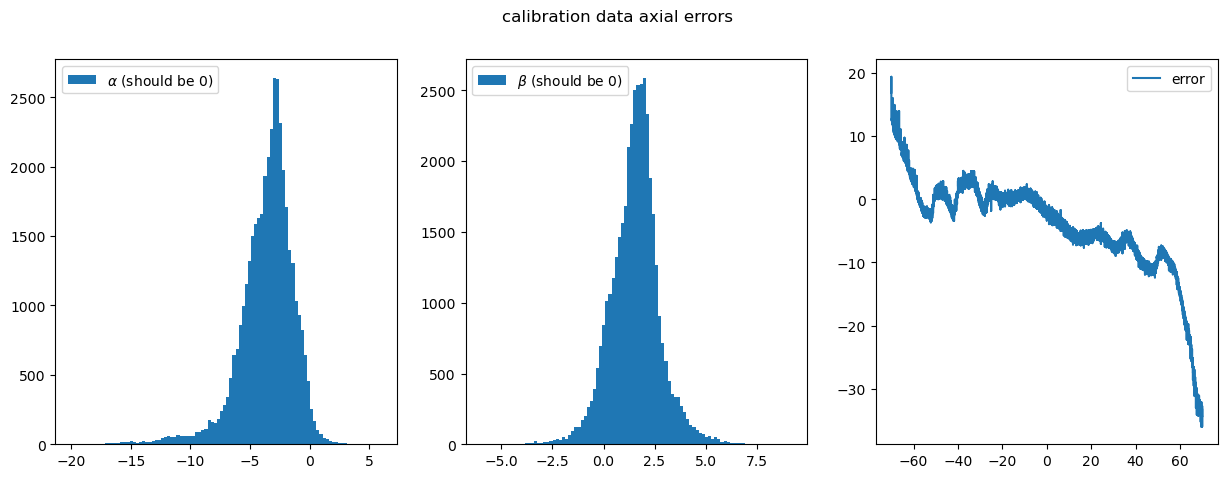

Average error accross


In [3]:
# look at sillyness at 0 and 90 deg
def axis_errors(data_set, title, save = False, path = None):
    data_180 = data_set[0]
    data_90 = data_set[2]
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
    fig.suptitle(title)
    ax[0].hist(data_90["angles"][0],bins=100, label = r"$\alpha$ (should be 0)")
    ax[0].legend()
    ax[1].hist(data_180["angles"][1],bins=100, label = r"$\beta$ (should be 0)")
    ax[1].legend()
    # error as function of angle doesn't matter which you pick
    ax[2].plot(data_180["true_angles"][0],data_180["angles"][0] - data_180["true_angles"][0], label = "error")
    ax[2].legend()
    plt.show()
    if save:
        plt.savefig(path)
    plt.close(fig)
    print("Average error accross")

axis_errors(calb_data, "calibration data axial errors")

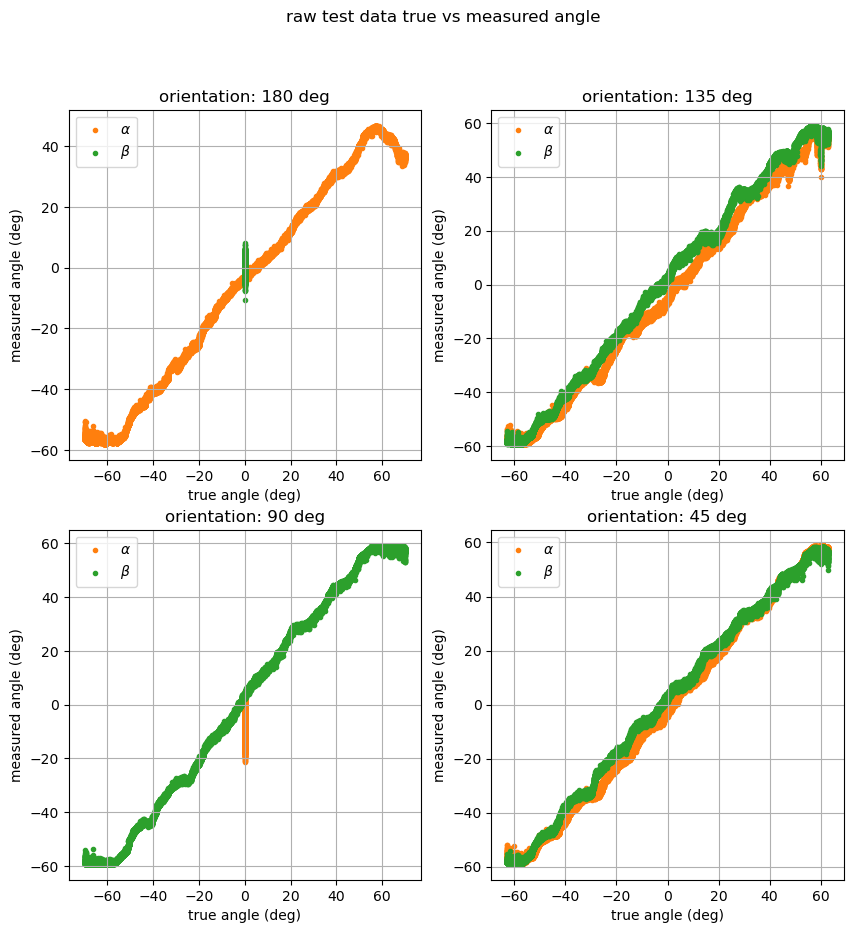

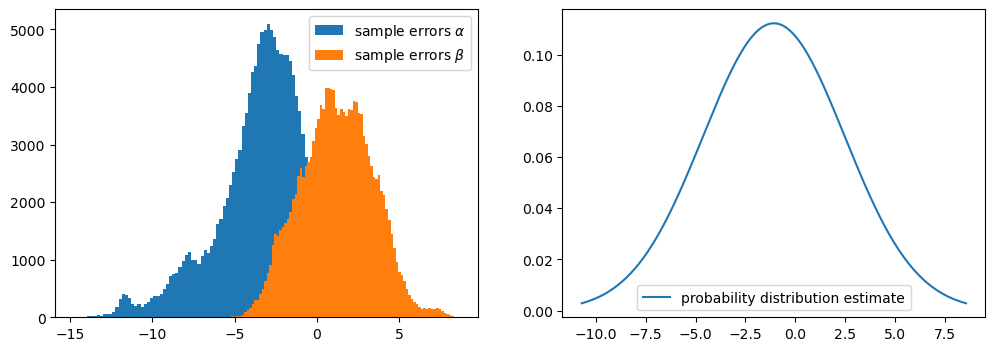

3.5 -1.0737842630853993 3.554617605421174
P value (distribution based) =  0.3465411994979761
P value based on samples:  0.2946728650137741


In [4]:
# plot the training data
test_save_raw_plot = os.path.join(plots,"test_save_raw_plot.png")
generic_angles(test_data, "raw test data true vs measured angle", save = True, path = test_save_raw_plot)
test_save_raw_error = os.path.join(plots,"test_save_raw_error.png")
error_set = error_distribution(test_data, title = "raw test data errors", save = True, path = test_save_raw_error)

Optimize with a bias/offset on the quadcell formula. Obviously, the quadcell can be programmed to have this offset
We now use:
$
    \frac{\tan{\alpha}}{\tan{\alpha_{max}}} = S_a - C_a \\
$
where $S_a$ is the quadcell formula. $\beta$ gets similar treatment. It is now a matter of finding optimal $C_a$ and $C_b$ that must be applicable to every orientation (it shouldn't matter how we place the sun sensor as long as it is properly alligned)

In [5]:
# get the offset coefficient tb used on a test set
def quad_formula(norm_quadrants):
    tan_a = norm_quadrants[0] + norm_quadrants[3] - norm_quadrants[2] - norm_quadrants[1]
    tab_b = norm_quadrants[0] + norm_quadrants[1]  - norm_quadrants[3] - norm_quadrants[2]
    return np.array([tan_a, tab_b])

def get_offset(data_set):
    # since the tangents are only 2 decimal numbers, use the quadrant info
    prep_quads = lambda data_partition : data_partition["quadrants"][:, data_partition["limits"]]/data_partition["totals"][data_partition["limits"]]
    prep_true_tans = lambda data_partition : data_partition["true_tangents"][:, data_partition["limits"]]
    # stack the tangents data in a convienient way
    tangents = np.hstack([quad_formula(prep_quads(data_set[i])) for i in range(4)])
    true_tangents = np.hstack([prep_true_tans(data_set[i]) for i in range(4)])
    loss_a = np.average(tangents[0] - true_tangents[0])
    loss_b = np.average(tangents[1] - true_tangents[1])
    return np.array([loss_a, loss_b])

# apply bias on test set and see
def apply_offset(data_set, bias):
    bias = bias.reshape(-1,1)
    # deepcopy is needed or python will just change the og data by reference
    corrected = []
    for i in range(4):
        data = copy.deepcopy(data_set[i])
        data["tangents"] -= bias
        data["angles"] = np.arctan(data["tangents"])*180/np.pi
        corrected.append(data)
    return corrected

bias = get_offset(calb_data)

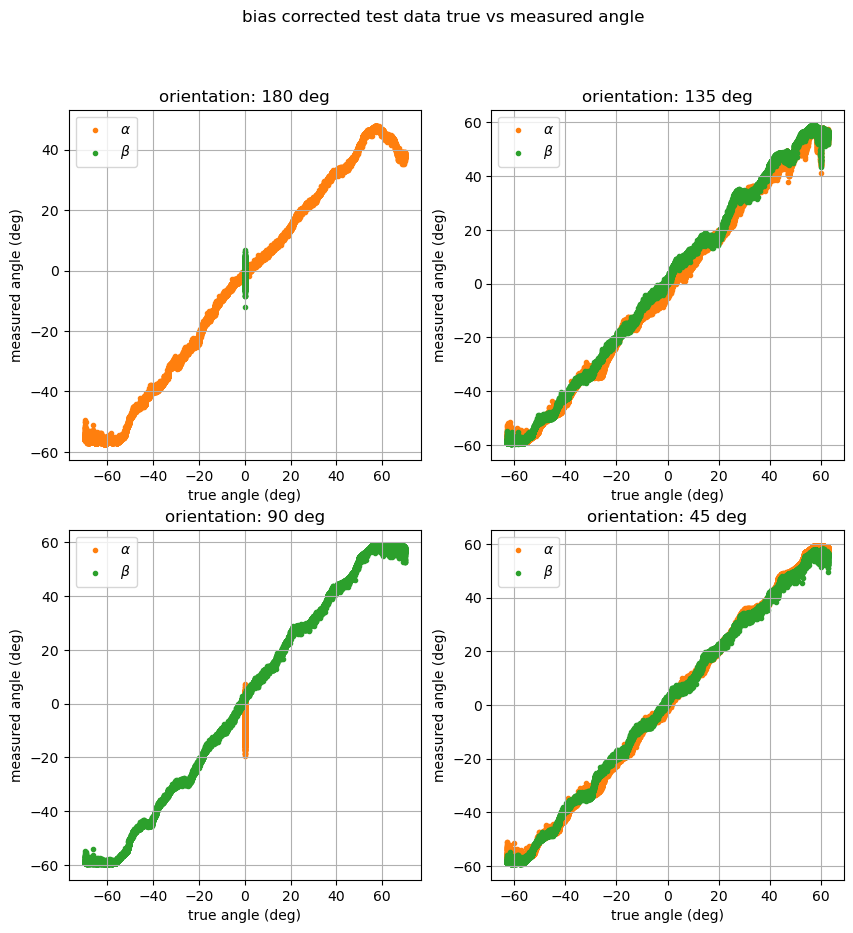

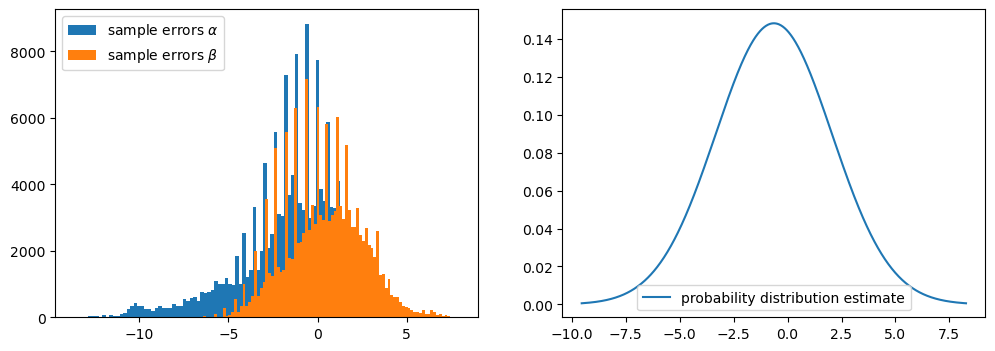

3.5 -0.6376815840131266 2.6944540032749447
P value (distribution based) =  0.2063644675614446
P value based on samples:  0.14352961432506883


In [6]:
# correct the test data
corrected_testset = apply_offset(test_data, bias)
# plot the test data
test_save_bias_plot = os.path.join(plots,"test_save_bias_plot.png")
generic_angles(corrected_testset, "bias corrected test data true vs measured angle", save = True, path = test_save_bias_plot)
test_save_bias_error = os.path.join(plots,"test_save_bias_error.png")
error_set_bias = error_distribution(corrected_testset, title = "bias corrected test data errors", save = True, path = test_save_bias_error)

Optimize with linear coefficients and bias/offset on the quadcell formula.
Also programmable in arduino

In [7]:
def OLS(data_set, yval = "alpha",regularization = 0.01, add_bias = False):
    # calculate the tangents based on a least squares estimator
    # default data is in transpose form
    assert yval in ["alpha", "beta"], "yval should be alpha or beta"
    if yval == "alpha":
        dig = 0
    elif yval == "beta":
        dig = 1
    # select the "good" cells for
    prep_quads = lambda data_partition : data_partition["quadrants"][:, data_partition["limits"]]/data_partition["totals"][data_partition["limits"]]
    quadrant_data_transpose = np.hstack([prep_quads(data_set[i]) for i in range(4)])
    prep_true_tans = lambda data_partition : data_partition["true_tangents"][:, data_partition["limits"]]
    true_tangents = np.hstack([prep_true_tans(data_set[i]) for i in range(4)])
    if add_bias:
        ones = np.full_like(quadrant_data_transpose[0],1).reshape(1,-1)
        quadrant_data_transpose = np.vstack((quadrant_data_transpose, ones))
    #print(quadrant_data_transpose[:,:10])
    quadrant_data = quadrant_data_transpose.T
    inverted_part = np.linalg.inv(np.dot(quadrant_data_transpose,quadrant_data) + regularization)
    estimator = np.dot(np.dot(inverted_part, quadrant_data_transpose), true_tangents[dig])
    return estimator

def apply_OLS(data_set, ols_a, ols_b, bias = False):
    # use the estimator to predict the tangenst and angles
    # note that to calculate the angles, even out of bounds values are used
    prep_quads = lambda data_partition : data_partition["quadrants"]/data_partition["totals"]
    # yes this should be applied to each data orientation separately
    # bc they must be returned separately
    corrected = []
    for k in range(4):
        data = copy.deepcopy(data_set[k])
        quadrant_transpose = prep_quads(data)
        if bias:
            ones = np.full_like(quadrant_transpose[0],1).reshape(1,-1)
            quadrant_transpose = np.vstack((quadrant_transpose, ones))
        data["tangents"] = np.array([np.dot(quadrant_transpose.T,ols_a), np.dot(quadrant_transpose.T,ols_b)])
        data["angles"] = np.arctan(data["tangents"])*180/np.pi
        corrected.append(data)
    return corrected

# calculate the estimator using calibration data [0], test it on [1]
estimator_alpha_1 = OLS(calb_data, yval="alpha", add_bias = True)
estimator_alpha_2 = OLS(calb_data, yval="alpha")
estimator_beta_1 = OLS(calb_data, yval="beta", add_bias = True)
estimator_beta_2 = OLS(calb_data, yval="beta")



In [8]:
estimator_alpha_1

array([ 1.67870561, -1.74080407, -1.64764837,  1.6214245 ,  0.08832233])

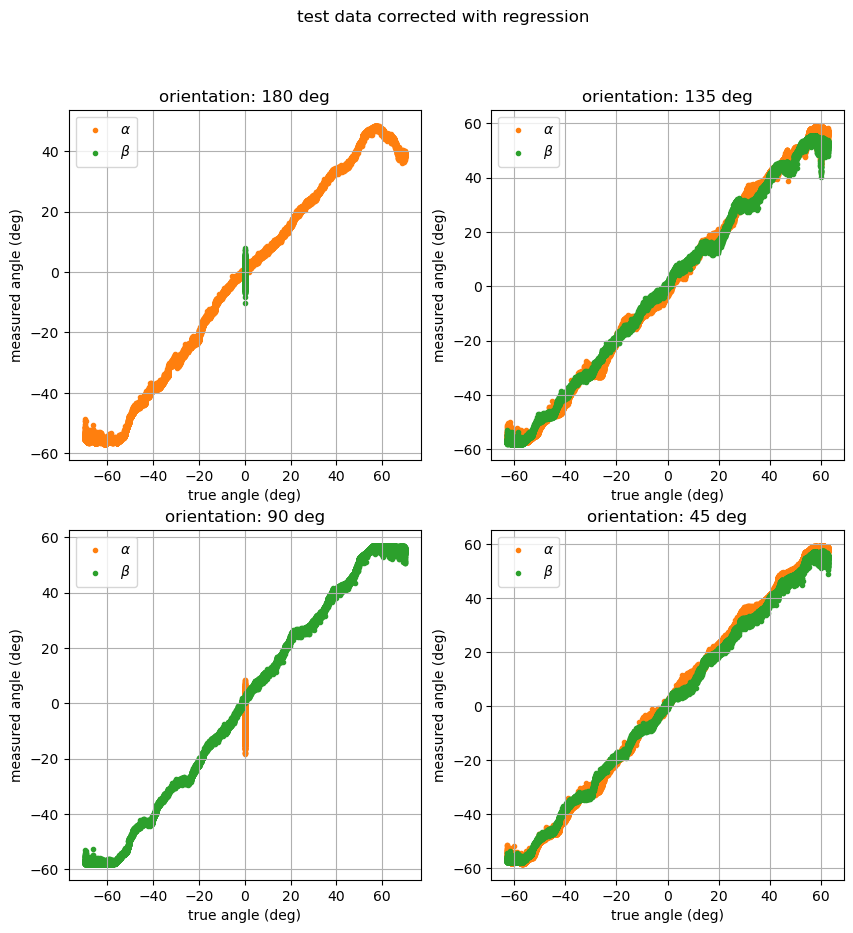

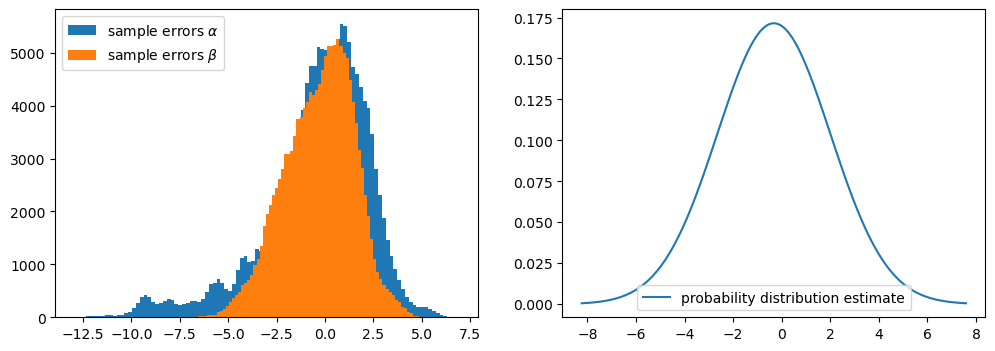

3.5 -0.3232948311297848 2.32632592767172
P value (distribution based) =  0.13618147848202694
P value based on samples:  0.10033057851239668


In [9]:
# apply regressor on test data
corrected_testset_ols = apply_OLS(test_data, estimator_alpha_1, estimator_beta_1, bias = True)
test_save_reg_plot = os.path.join(plots,"test_save_reg_plot.png")
generic_angles(corrected_testset_ols, "test data corrected with regression", save = True, path = test_save_reg_plot)
test_save_reg_error = os.path.join(plots,"test_save_reg_error.png")
error_set_reg = error_distribution(corrected_testset_ols, title = "regression corrected test data errors", save = True, path = test_save_reg_error)

Truth table based on nearest neighbors

In [34]:
def lookup_table(data_set, averaging = 100):
    # the table include quadrant info and their specific true angles
    prep_quads = lambda data_partition : data_partition["quadrants"][:, data_partition["limits"]]/data_partition["totals"][data_partition["limits"]]
    prep_true_ang = lambda data_partition : data_partition["true_angles"][:, data_partition["limits"]]
    #only calibrate within limit quadrants
    quadrants = np.hstack([prep_quads(data_set[i]) for i in range(4)])
    quadrants_split = np.array(np.split(quadrants, len(quadrants[0])/averaging, axis = 1))
    quadrant_average = np.average(quadrants_split, axis = 2)
    quadrant_variance = np.var(quadrants_split, axis = 2)
    distance_estimate = np.sum(quadrant_variance,axis=1)
    true_angles = np.hstack([prep_true_ang(data_set[i]) for i in range(4)])
    true_angles_avg = true_angles[:,::averaging]
    table = {"quadrants" : quadrant_average, "true_angles" : true_angles_avg, "quadrant_variance": distance_estimate}
    return table

def apply_table(data_set, LUT):
    prep_quads = lambda data_partition : data_partition["quadrants"]/data_partition["totals"]
    data = copy.deepcopy(data_set)
    for k in range(4):
        data_part = copy.deepcopy(data[k])
        quadrants = prep_quads(data_part).T
        # again correction will be applied to each orientation separately
        print(data[k]["angles"].shape)
        print(LUT["true_angles"].shape)
        for i in range(len(quadrants[:,0])):
            distance = np.sqrt(np.sum((quadrants[i] - LUT["quadrants"])**2,axis=1))
            index = distance.argmin()
            data[k]["angles"][:,i] = LUT["true_angles"][:,index]
    return data

table = lookup_table(calb_data)
calibrated_lookup_data = apply_table(calb_data, table)

(2, 40300)
(2, 1452)
(2, 40300)
(2, 1452)
(2, 40300)
(2, 1452)
(2, 40300)
(2, 1452)


(2, 40300)
(2, 1452)
(2, 40300)
(2, 1452)
(2, 40300)
(2, 1452)
(2, 40300)
(2, 1452)


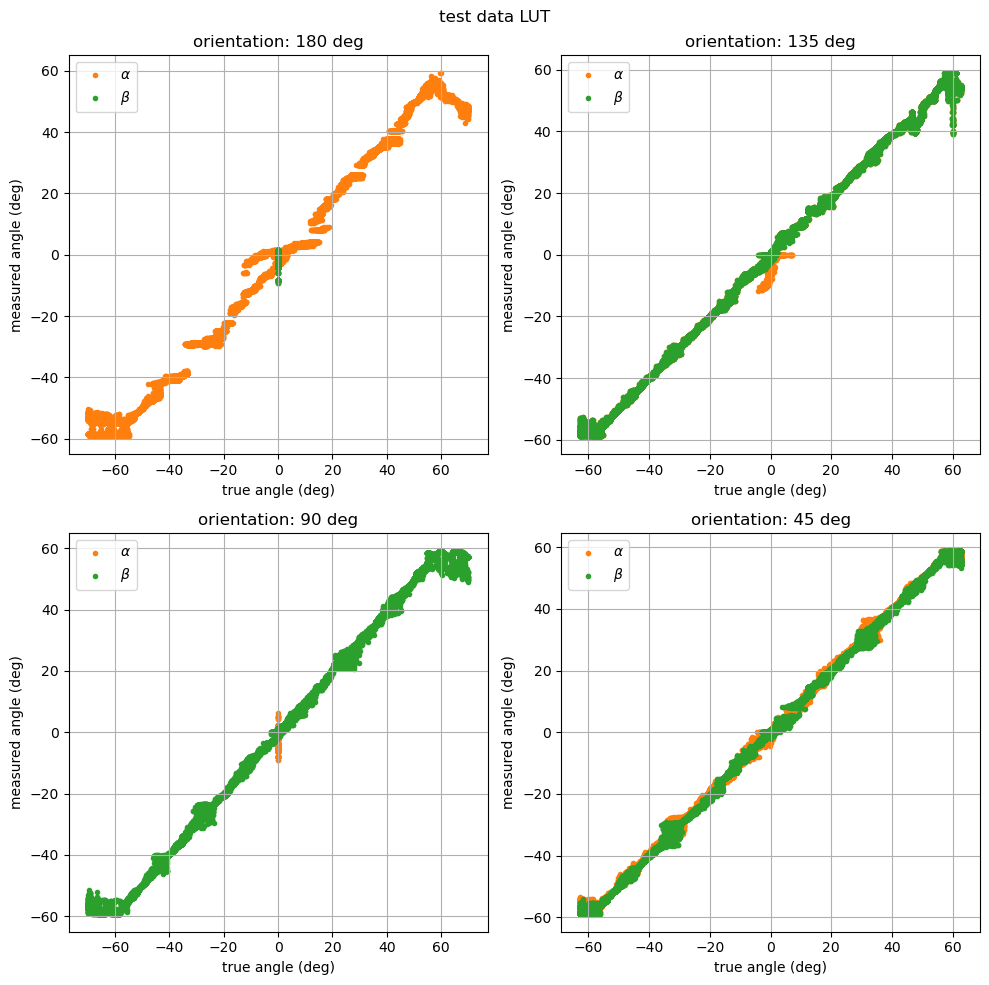

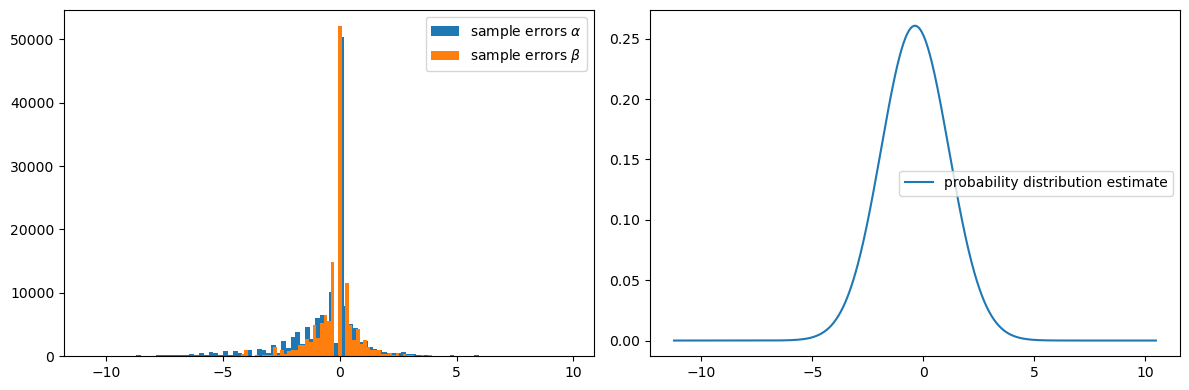

3.5 -0.37290184262440806 1.5297500643242106
P value (distribution based) =  0.026142640445754692
P value based on samples:  0.04541666666666666


In [35]:
# do the same for the test data
test_lookup_data = apply_table(test_data, table)
test_save_LUT_plot = os.path.join(plots,"test_save_LUT_plot.png")
generic_angles(test_lookup_data, "test data LUT", save = True, path = test_save_LUT_plot)
test_save_LUT_error = os.path.join(plots,"test_save_LUT_error.png")
error_set_LUT = error_distribution(test_lookup_data, title = "LUT test data errors", save = True, path = test_save_LUT_error)

Discontinuities in the cells are preventing "good" calibration

0


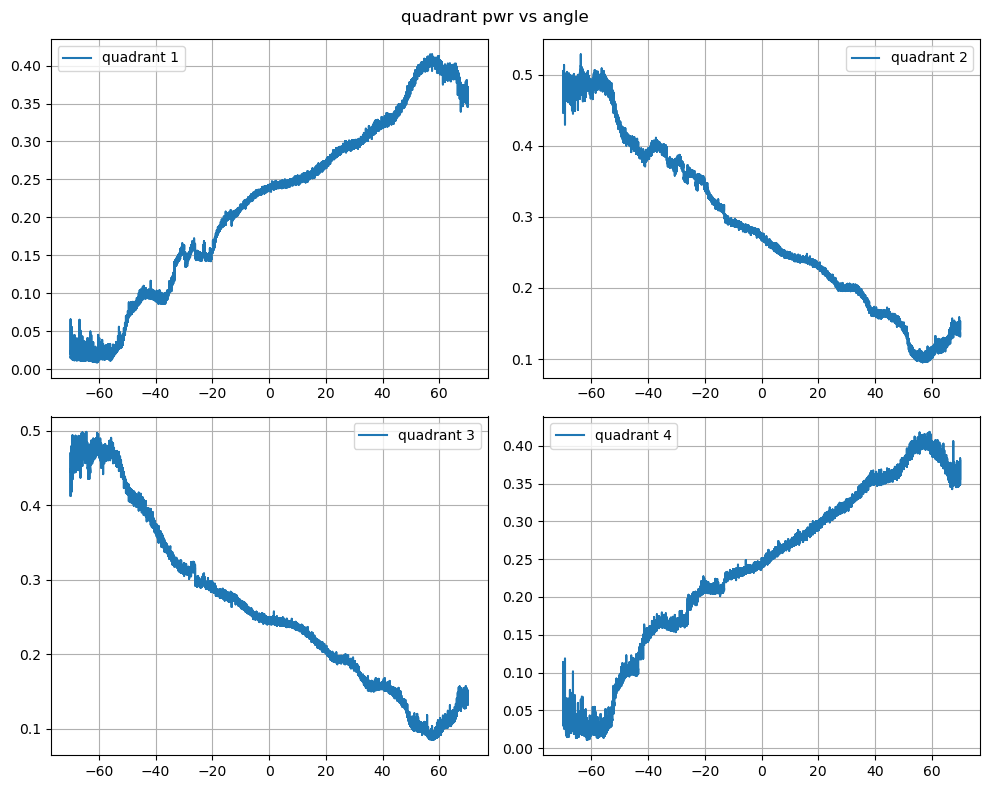

'bitch'

In [36]:
def plot_quadrant(data_set, orientation, true_angle = "alpha", title = None, save = False, path = None):
    assert true_angle in ["alpha", "beta"]
    true_angle = 0
    if true_angle == "beta":
        true_angle = 1
    orientations = np.array([180,135,90,45])
    oidx = np.where(orientations == orientation)[0][0]
    print(oidx)
    angle = data_set[oidx]["true_angles"][true_angle]
    fig, ax = plt.subplots(nrows=2,ncols=2,figsize = (10,8))
    for k in range(4):
        quad_data = data_set[oidx]["quadrants"][k]/data_set[oidx]["totals"]
        j, i = k, 0
        if k > 1:
            j, i = k - 2, 1
        ax[i][j].plot(angle, quad_data, label = f"quadrant {k+1}")
        ax[i][j].grid()
        ax[i][j].legend()
    fig.suptitle(title)
    plt.tight_layout()
    if save:
        plt.savefig(path)
    plt.show()
    plt.close()
    return "bitch"

sussy_quadrants = os.path.join(plots,"sussy_quadrants.png")
plot_quadrant(test_data, 180, "alpha", "quadrant pwr vs angle", save =True, path = sussy_quadrants)